# Variations on Competitive Contagions in Cascade Networks
### Robert Choi

## Abstract
In this project, I explore the outcomes of three competitive contagion models proposed by Kearns et al..  The switching/selection model of competitive contagion has been written out and implemented here in python code.  Different possibilities for switching and selection functions are defined, and their typical probabilistic outcomes illustrated by running the model under different variations.  Afterwards, I present examples of Nash Equilibria resulting from this model and explain the effects that various parameters have on Nash Equilibria outcomes.  Finally, I explain and run two other variations on the switching/selection model proposed at a later time by Kearns et al..

## Introduction
Cascade behavior networks are frequently used as a means of modeling the "viral" adoption of a service or product by a population; that is, Cascade behavior networks effectively illustrate the spread of a product's use as a result of exposure to that product through an individual's social network.  One aspect of product promotion that traditional cascade models, such as the linear threshold model, do not capture is competition between similar products or services.  From smartphones, to social media platforms, to video game consoles, to computer hardware, there are numerous fields where similar products compete to fill the same niche in consumers' lives.  It's in the spirit of addressing these sorts of problems that Kearns et al. proposed one of the first competitive contagion models for cascade behavior networks.

Kearns's model is named the switching/selection model for its signature two-step updating process.  In the first step, a switching function determines whether nodes exposed to neighboring nodes carrying either of the competing contagions will be "infected."  In the second step, a selection function determines which of the competing contagions nodes that are to become infected will catch.  The initial adopters of each contagion are selected by each of the "players" (typically represented as R meaning "red" and B meaning "blue") according to an allocated budget of nodes which they can "seed."  The competing players' selections for starting seeds constitute the joint strategies, which we can evaluate for their stochastic payoffs and for their status as Nash Equilibria or otherwise.  

## Preliminaries
Definition of terms:
##### Budget
For player p = R,B, the budget Kp is the number of nodes that player p will choose as starting seeds.  In cases where players R and B choose the same node as a starting seed, the assigned contagion of that node will be determined probabilistically based upon the proportion of nodes allocated to each player up to that point.  To be specific, the probability of a contested node being assigned red is equal to the number of nodes allocated red, over the total number of nodes allocated; the inverse is true for blue.  The initial allocations of players R and B are written jointly as (σR , σB).
##### Switching Function
Written as f(x), where x is the fraction of a node's neighbors which are currently infected.  The function maps the fraction x to some probability between 0 and 1, where f(1) always equals 1 and f(0) always equals 0.  The probability given by f(x) represents the probability that some uninfected node will become infected.
##### Selection Function
Written as g(y), where y is the fraction of a node's infected neighbors which are infected either red or blue.  The function maps the fraction y to some probability between 0 and 1, where g(1) always equals 1 and g(0) always equals 0.  The probability given by g(y) represents the probability that a node, which the switching function has already determined will become infected, will become infected by either red or blue.
##### Immunity
In the switching/selection model, once a node has become exposed to infection (i.e. one of its neighbors is infected) and that node either becomes infected or remains uninfected, it is considered immune.  That is to say, it will no longer be considered for an update in state; infected nodes cannot become uninfected or switch to the other contagion; immune nodes that are uninfected cannot become infected in subsequent updates.
##### Budget Multiplier
Measures the extent to which increases in a player's budget will translate to increases in the player's payoff.  For instance, if doubling my budget doubles my payoff, the budget multiplier is 1.  If doubling my budget increases my payoff by times 20, then the budget multiplier is 10.  The budget multiplier is given by the expression:
ΠR(σR,σB) × KB over
ΠB(σR,σB) × KR

## Algorithms
For the switching and selection functions f(x) and g(y), Kearns et al. suggest the following as a general model for various situations:
##### Switching Function
f(x)=x^r r≥0
In this formulation, r = 1 is linear: the probability that a node will become infected is equal to the fraction of its neighbors that are infected.  When r < 1, the function is called concave; in such a function, the probability of infection is relatively high for only a small fraction of infected neighbors, but the probability of infection increases less dramatically as the fraction of infected neighbors approaches 1.  The inverse is true for r > 1: the function is called convex, and the probability of infection remains quite low until the fraction of infected neighbors nears 1, at which point the probability increases significantly.
##### Selection Function
g(y)=y^s/(y^s +((1−y)^s) s≥0.
Kearns et al. borrow the Tullock contest function for their selection function.  Here, s = 1 is linear: the probability that a node will become infected red is equal to the fraction of its infected neighbors that are red.  When s < 1, the selection function is called equalizing, because the minority player among the node's neighbors has a better chance of securing the infection.  When s > 1, the selection function is called polarizing, because the majority player is more likely to dominate the infected node.  When s = 0, the selection function is a constant 1/2, meaning there is an equal probability of an infected node picking up either infection, regardless of the proportion of neighbors infected by either player.

## Implementing the model
### Graph Creation
Create a graph to experiment on, using the Barabasi-Albert model of graph.

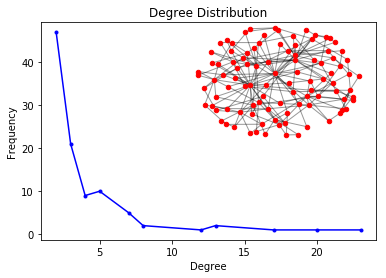

In [2]:
#Robert Choi
#Bowdoin College
#May 10, 2017
#Code modified in large part from cascade network code developed by Professor Irfan

import networkx as nx
import matplotlib.pyplot as plt

n = 100
m = 2

def create_graph(n, m):
    G = nx.barabasi_albert_graph(n, m)
    deg_seq = nx.degree(G).values()
    deg_freq = {} #dictionary of degree frequencies

    #Instantiate the dictionary
    for d in deg_seq:
        if d not in deg_freq:
            deg_freq[d] = 1
        else:
            deg_freq[d] += 1

    deg_freq_sorted = sorted(deg_freq.items())

    plt.plot([d for (d,v) in deg_freq_sorted], [v for (d,v) in deg_freq_sorted],'b-',marker='.')
    plt.title("Degree Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")

    #Draw graph in inset
    plt.axes([0.45,0.45,0.45,0.45])
    Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)[0]
    pos=nx.spring_layout(Gcc)
    plt.axis('off')
    nx.draw_networkx_nodes(Gcc,pos,node_size=20)
    nx.draw_networkx_edges(Gcc,pos,alpha=0.4)

    #plt.savefig("degree_histogram.png")
    plt.show()
    
    return G

G = create_graph(n, m)

### Initialize the Starting Allocations

In [3]:
import numpy as np, random

#Select (1-p) fraction of nodes as initial adopters randomly
#p_r represents budget of R, p_b of B
#Implementation of this function aims to balance two factors:
#players choose their initial seeds randomly, but they also
#are guaranteed and limited by a certain number of allocations, 
#not to say that, after conflicts, both players will control equal nodes.
def select_random(p_r, p_b, n):
    r = [0 for i in range(n)]
    b = [0 for i in range(n)]
    K_r = int(p_r * n)
    K_b = int(p_b * n)
    num_r = 0
    num_b = 0
    i = 0
    #Players choose nodes until they've been able to allocate their budget
    while num_r < K_r or num_b < K_b:
        random_num_r = random.random() #between [0, 1)
        random_num_b = random.random()
        arbitrator = random.random()
        #only nodes that have not yet been claimed are considered
        if r[i] == 0 and b[i] == 0:
            #Player chooses to seed a node randomly, and only if they have
            #not yet spent their budget
            if random_num_r <= p_r and num_r < K_r:
                r[i] = 1
                num_r += 1
            if random_num_b <= p_b and num_b < K_b:
                b[i] = 1
                num_b += 1
            #Arbitrate outcome if both R and B choose a node
            if random_num_r <= p_r and random_num_b <= p_b and num_r < K_r and num_b < K_b:
                #Fraction of nodes currently claimed by R
                proportion_r = sum(r)/(sum(r)+sum(b))
                #The player with lower proportion of claimed nodes
                #has higher probability of claiming contested nodes
                if arbitrator >= proportion_r:
                    b[i] = 0
                else:
                    r[i] = 0
        if i < n-1:
            i += 1
        else:
            i = 0
    return r, b

#Initialize array that indicates whether or not a node is up to be
#infected
def infect_immunize(r, b, n):
    infected = [0 for i in range(n)]
    immune = [0 for i in range(n)]
    for i in range(n):
        #Already infected nodes are not up for updating
        if r[i] == 1 or b[i] == 1:
            infected[i] = 1
            immune[i] = 1
    return infected, immune

p_r = 0.2 #R's budget = p_r * n
p_b = 0.2 #B's budget = p_b * n
r, b = select_random(p_r, p_b, n)

#Save original values for running multiple trials
def save_r_b_copy(r, b, n):
    original_r = [0 for i in range(n)]
    original_b = [0 for i in range(n)]
    for i in range(n):
        if r[i] == 1:
            original_r[i] = 1
        if b[i] == 1:
            original_b[i] = 1
    return original_r, original_b

original_r, original_b = save_r_b_copy(r, b, n)

### Draw network before the cascade process starts

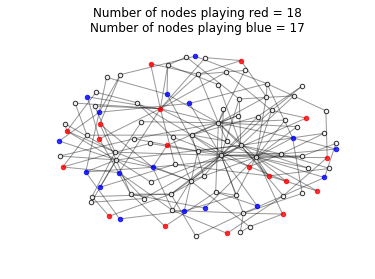

In [4]:
#Draw graph
def draw_graph(G, n):
    Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)[0]
    pos=nx.spring_layout(Gcc)
    plt.axis('off')

    #Draw nodes
    x_u = [] #Nodes playing U
    x_r = [] #Nodes playing R
    x_b = [] #Nodes playing B
    for i in range(n):
        if r[i] == 1:
            x_r.append(i)
        elif b[i] == 1:
            x_b.append(i)
        else:
            x_u.append(i)
    nodes = nx.draw_networkx_nodes(G,pos,
                           nodelist=x_u,
                           node_color='w',
                           node_size=20,
                           alpha=0.8)
    if (len(x_u) > 0):
        nodes.set_edgecolor('black')
    nx.draw_networkx_nodes(G,pos,
                           nodelist=x_r,
                           node_color='r',
                           node_size=20,
                           alpha=0.8)
    nx.draw_networkx_nodes(G,pos,
                           nodelist=x_b,
                           node_color='b',
                           node_size=20,
                           alpha=0.8)

    nx.draw_networkx_edges(Gcc,pos,alpha=0.4)
    plt.title("Number of nodes playing red = "+ str(len(x_r)) + "\nNumber of nodes playing blue = "+ str(len(x_b)))
    plt.show()
    
draw_graph(G, n)

### Run the cascade process
Note: this block of code can be run multiple times, each time using the same initial infected nodes.


Test 1
Iter = 1 # of nodes playing red = 18 
         # of nodes playing blue = 17
Iter = 2 # of nodes playing red = 31 
         # of nodes playing blue = 27


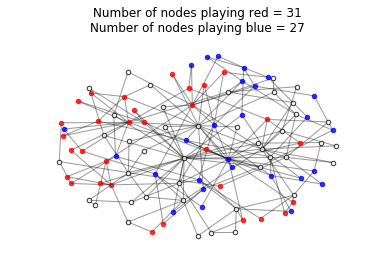

Test 2
Iter = 1 # of nodes playing red = 18 
         # of nodes playing blue = 17
Iter = 2 # of nodes playing red = 37 
         # of nodes playing blue = 28


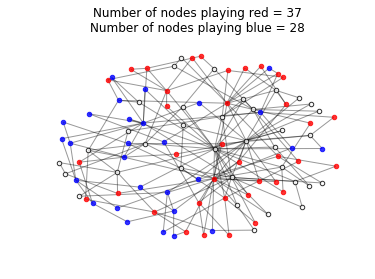

Test 3
Iter = 1 # of nodes playing red = 18 
         # of nodes playing blue = 17
Iter = 2 # of nodes playing red = 47 
         # of nodes playing blue = 22


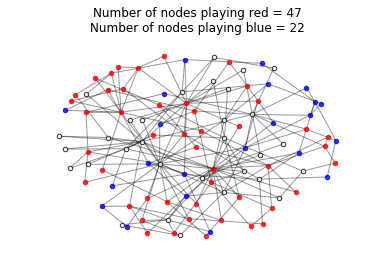

Test 4
Iter = 1 # of nodes playing red = 18 
         # of nodes playing blue = 17
Iter = 2 # of nodes playing red = 45 
         # of nodes playing blue = 23
Iter = 3 # of nodes playing red = 46 
         # of nodes playing blue = 23


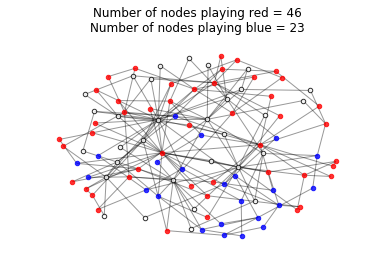

Test 5
Iter = 1 # of nodes playing red = 18 
         # of nodes playing blue = 17
Iter = 2 # of nodes playing red = 32 
         # of nodes playing blue = 22


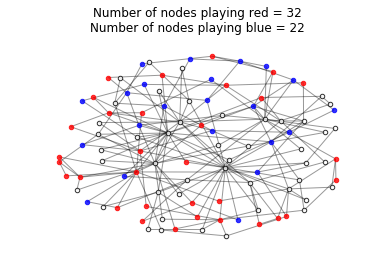

In [5]:
def reset_r_b(n):
    r = [0 for i in range(n)]
    b = [0 for i in range(n)]
    for i in range(n):
        if original_r[i] == 1:
            r[i] = 1
        if original_b[i] == 1:
            b[i] = 1
    return r, b

#f(), determines if node becomes infected
def switching_function(num_neighbors, num_infected_neighbors, R):
    #Probability of infection determined by fraction of
    #neighbors infected
    infection_chance = (num_infected_neighbors/num_neighbors) ** R
    random_num = random.random()
    if random_num <= infection_chance:
        return 1
    else:
        return 0
    
#g(), determines which player infects a node
def selection_function(num_r, num_b, num_i, S):
    #Probability of red infection determined by fraction
    #of neighbors infected by red
    infection_chance_r = ((num_r/num_i) ** S)/(((num_r/num_i) ** S) + ((num_b/num_i) ** S))
    random_num = random.random()
    if random_num <= infection_chance_r:
        return 1
    else:
        return 0

def run_cascade(r, b, R, S, n):
    infected, immune = infect_immunize(r, b, n)
    iter = 0
    while True:
        num_red = sum(r)
        num_blue = sum(b)
        num_infected = num_red + num_blue
        iter += 1
        print("Iter =", iter, "# of nodes playing red =", num_red, 
                   "\n         # of nodes playing blue =", num_blue)
        x_next = [infected[i] for i in range(n)]
        #Calculate the new action of each node
        for i in range(n):
            #Only non-immune nodes are up for update
            if immune[i] == 0:
                #Check for infected neighbors
                num_infected_neighbors = 0
                num_red_neighbors = 0
                num_blue_neighbors = 0
                for j in G.neighbors(i):
                    if infected[j] == 1:
                        immune[i] = 1
                        #Record neighbor infection status for later
                        num_infected_neighbors += 1
                        num_red_neighbors += r[j]
                        num_blue_neighbors += b[j]
                #Infection attempt in progress!
                if immune[i] == 1:
                    infected[i] = switching_function(len(G.neighbors(i)), 
                                                     num_infected_neighbors, R)
                #Successfully infected, but by who?
                if infected[i] == 1:
                    num_infected += 1
                    r[i] = selection_function(num_red_neighbors, num_blue_neighbors, 
                                              num_infected_neighbors, S)
                    b[i] = 1 - r[i]     

        #Break if there's no change in the #
#         print(sum(x_next))
#         print(num_infected)
        if (sum(x_next) == num_infected):
            break
     
num_tests = 5
for i in range(num_tests):
    print("Test", i+1)
    r, b = reset_r_b(n)
    run_cascade(r, b, 1, 1, n)
    draw_graph(G, n)

### Illustrating Effect of R on f(x)
This series of iterations on the cascade process illustrates the effect of varying r values on the switching function.  When r = 0, the probability that a node neighboring an infected node will become infected on this update cycle is 1, meaning all nodes in the graph will become infected.  As r increases past 1, the number of total nodes infected will decrease, given that a greater proportion of infected neighbors is necessary to cause an infection.

R = 0 S = 1
Iter = 1 # of nodes playing red = 18 
         # of nodes playing blue = 17
Iter = 2 # of nodes playing red = 36 
         # of nodes playing blue = 64


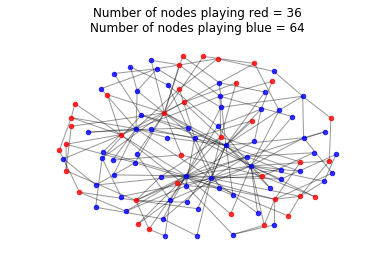

R = 1 S = 1
Iter = 1 # of nodes playing red = 18 
         # of nodes playing blue = 17
Iter = 2 # of nodes playing red = 27 
         # of nodes playing blue = 30
Iter = 3 # of nodes playing red = 28 
         # of nodes playing blue = 30


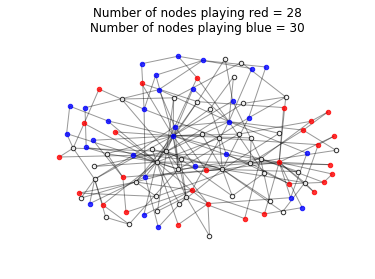

R = 2 S = 1
Iter = 1 # of nodes playing red = 18 
         # of nodes playing blue = 17
Iter = 2 # of nodes playing red = 24 
         # of nodes playing blue = 22


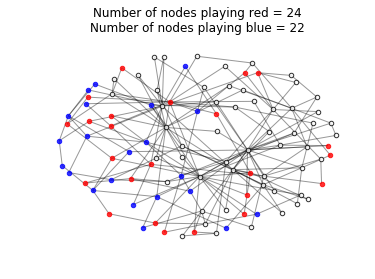

R = 3 S = 1
Iter = 1 # of nodes playing red = 18 
         # of nodes playing blue = 17
Iter = 2 # of nodes playing red = 24 
         # of nodes playing blue = 19


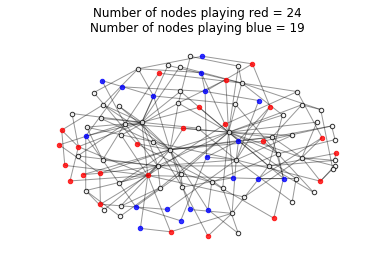

R = 4 S = 1
Iter = 1 # of nodes playing red = 18 
         # of nodes playing blue = 17
Iter = 2 # of nodes playing red = 20 
         # of nodes playing blue = 21


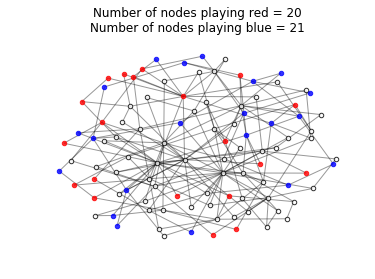

In [6]:
num_tests = 5
for i in range(num_tests):
    print("R =", i, "S = 1")
    r, b = reset_r_b(n)
    run_cascade(r, b, i, 1, n)
    draw_graph(G, n)

### Illustrating effect of S on g(x)
The effect of s on the selection function is more difficult to illustrate than that of r on the switching function, but this demonstration should provide some clarity.  Here, s is set to s = 0, so g(y) = 1/2 for any proportion of red/blue neighbors that is not 1 or 0.  In the case that a nodes infected neighbors are all either red or blue, the probability that the node will acquire the same infection is 1; however, as long as each player is represented by at least 1 neighboring node, the probability that the infected node will acquire red or blue is 1/2.  In this example, the starting allocations of the blue player are erased, marked uninfected.  Then, a single blue seed is placed at the node with the highest degree in the graph.  For each node that this blue node neighbors, the probability that it will acquire the blue infection is 1/2, which explains the disproportionate representation of blue in the resulting graph.

R = 0 S = 0
Iter = 1 # of nodes playing red = 18 
         # of nodes playing blue = 0
Iter = 2 # of nodes playing red = 65 
         # of nodes playing blue = 35


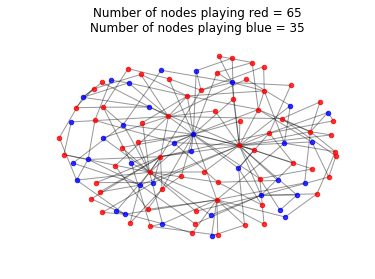

In [7]:
def find_node_highest_degree(G):
    max_degree = 0
    max_degree_node = 0
    for i in G.nodes():
        if G.degree(i) > max_degree:
            max_degree = G.degree(i)
            max_degree_node = i
    return max_degree_node

max_degree_node = find_node_highest_degree(G)

print("R = 0 S = 0")
r, b = reset_r_b(n)
b = [0 for i in range(n)]
b[max_degree_node]
run_cascade(r, b, 0, 0, n)
draw_graph(G, n)

## Equilibria Examples
In this section, I will implement the hypothetical Nash Equilibria that Kearns et al. use to demonstrate the effects of r on f(x) and s on g(y) with regards to contagion outcomes.

### Example 1: Linear vs Convex Switching Function
In this example, the graph consists of two "components", one of 10 vertices, the other of 100 vertices.  In each component, 2 vertices are influential, each of the two possessing an edge with the other non-influential nodes, 8 in the first component and 98 in the second.  Each player is allowed a budget of 1 node.  Given a linear switching function, the Nash Equilibrium (bearing in mind that the Nash Equilibrium is based upon expected outcomes because outcomes are probabilistic) consists in the two competing players seeding the two influential nodes of the larger second component.  Because for each of the non-influential nodes in this component the proportion of neighbors that is infected is 1, each is guaranteed to become infected.  The probability for each acquiring either red or blue is 1/2, because the proportion of each is equal among each non-influential node's neighbors.  Therefore, the expected payoff for each player is 50.  This initial allocation is a Nash Equilibrium because neither player has incentive to unilaterally deviate.  Obviously, neither player will want to deviate to a non-influential node.  Even if both players had initially seeded the influential nodes in the smaller component, both players would have incentive to unilaterally switch, as the expected payoff for seeding the smaller component would be 1/2 x 10 = 5, whereas the expected payoff of seeding the larger component alone would be 1/2 x 100 = 50.

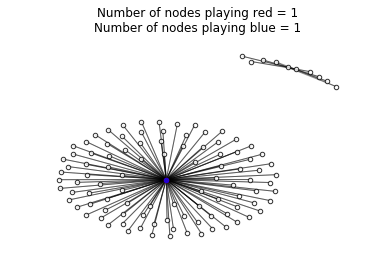

After contagion:
Iter = 1 # of nodes playing red = 1 
         # of nodes playing blue = 1
Iter = 2 # of nodes playing red = 44 
         # of nodes playing blue = 56


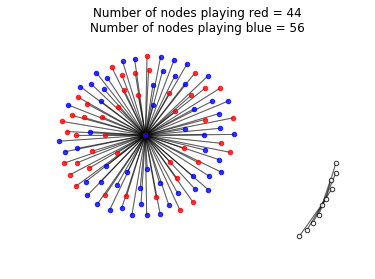

In [8]:
def draw_example_graph(G, n):
    pos = nx.fruchterman_reingold_layout(G)

    plt.axis('off')

    #Draw nodes
    x_u = [] #Nodes playing U
    x_r = [] #Nodes playing R
    x_b = [] #Nodes playing B
    for i in range(n):
        if r[i] == 1:
            x_r.append(i)
        elif b[i] == 1:
            x_b.append(i)
        else:
            x_u.append(i)
    nodes = nx.draw_networkx_nodes(G,pos,
                           nodelist=x_u,
                           node_color='w',
                           node_size=20,
                           alpha=0.8)
    if (len(x_u) > 0):
        nodes.set_edgecolor('black')
    nx.draw_networkx_nodes(G,pos,
                           nodelist=x_r,
                           node_color='r',
                           node_size=20,
                           alpha=0.8)
    nx.draw_networkx_nodes(G,pos,
                           nodelist=x_b,
                           node_color='b',
                           node_size=20,
                           alpha=0.8)

    nx.draw_networkx_edges(G,pos,alpha=0.4)
    plt.title("Number of nodes playing red = "+ str(len(x_r)) + "\nNumber of nodes playing blue = "+ str(len(x_b)))
    plt.show()
  
def example_graph_1(x, y):
    G=nx.Graph()
    G.clear()
    n = 110

    G.add_nodes_from(range(110))

    for i in range(2):
        for j in range(2, 10):
            G.add_edge(i, j)

    for i in range(10, 12):
        for j in range(12, 110):
            G.add_edge(i, j)

    r = [0 for i in range(n)]
    b = [0 for i in range(n)]

    r[x] = 1
    b[y] = 1
    
    return G, n, r, b

G, n, r, b = example_graph_1(10 ,11)
original_r, original_b = save_r_b_copy(r, b, n)
draw_example_graph(G, n)
print("After contagion:")
run_cascade(r, b, 1, 1, n)
draw_example_graph(G, n)

However, in the case of a convex switching function with sufficiently large r, both players seeding the influential nodes of the smaller nodes becomes a Nash Equilibrium.  When r becomes sufficiently large, the probability of a node becoming infected when only 1/2 of its neighbors are infected dips below 1/25.  Given that both players initially seed the influential nodes of the smaller component, then, neither will want to deviate to seeding one of the influential nodes of the larger component, as the expected payoff from seeding the larger component alone is only 1/25 x 100 = 4, whereas the expected payoff for remaining and seeding the smaller component along with the competitor is 1/2 x 10 = 5.  Whereas when the switching function was linear there was only one unique Nash Equilibrium, when the switching function is convex, the introduction of this inferior Nash Equilibrium causes the price of anarchy to hike significantly.

R and B on small component:


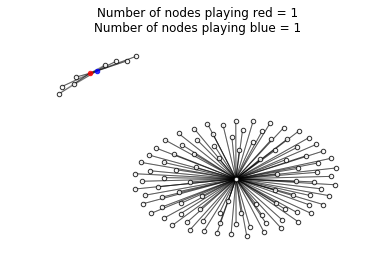

After contagion:
Iter = 1 # of nodes playing red = 1 
         # of nodes playing blue = 1
Iter = 2 # of nodes playing red = 6 
         # of nodes playing blue = 4


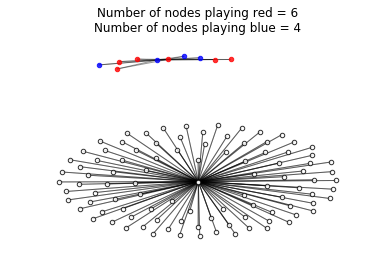

One of the players deviates:


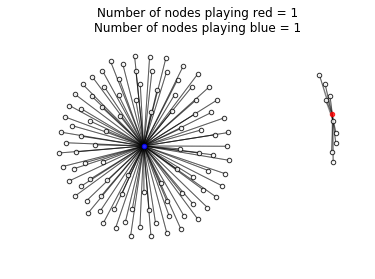

After contagion:
Iter = 1 # of nodes playing red = 1 
         # of nodes playing blue = 1
Iter = 2 # of nodes playing red = 1 
         # of nodes playing blue = 5


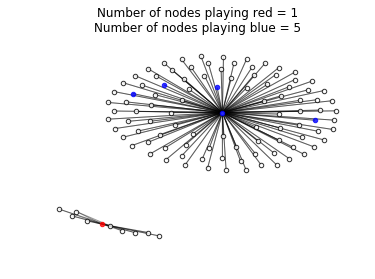

In [9]:
print("R and B on small component:")
G, n, r, b = example_graph_1(0, 1)
original_r, original_b = save_r_b_copy(r, b, n)
draw_example_graph(G, n)
print("After contagion:")
run_cascade(r, b, 4, 1, n)
draw_example_graph(G, n)

print("One of the players deviates:")
G, n, r, b = example_graph_1(0, 10)
original_r, original_b = save_r_b_copy(r, b, n)
draw_example_graph(G, n)
print("After contagion:")
run_cascade(r, b, 4, 1, n)
draw_example_graph(G, n)

### Effect of Convex f(x) on Budget Multiplier
In this example, the graph consists of one component of 100 nodes.  The component consists of three influential nodes, each possessing an edge with the other 97 non-influential nodes.  Player red, it is assumed, has budget Kr = 1, while player blue has budget Kb = 2.  The budget of blue, then, is twice that of red.  The Nash Equilibrium given a linear switching function is for each player to allocate their respective budgets such that R seeds one of the influential nodes and B seeds the other two.  In this case, the expected payoff for R is 1/3 x 100, and the expected payoff for B is 2/3 * 100; the budget multiplier, therefore, is 1 because doubling B's budget had the effect of doubling B's payoff relative to R.  R deviating to either of the influential nodes claimed by B will cause R's expected payoff to drop to 1/2 x 1/2 x 100: 1/2 chance that the contested node is awarded to R, 1/2 chance that every neighboring node of the initial seed is infected by R, for 100 nodes.  

If the switching function is convex, such that f(2/3) gives a node a 1/25 chance of becoming infected, this arrangement is still a Nash Equilibrium, but the budget multiplier increases to around 50 to account for the drastic reduction in the payoffs for R should R choose to deviate.  The expected payoff for R in this case would be 1/2 x 1/2 x 1/25 x 100.

Linear switching function:


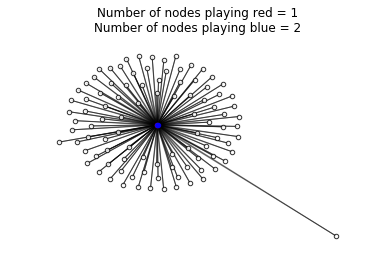

After contagion:
Iter = 1 # of nodes playing red = 1 
         # of nodes playing blue = 2
Iter = 2 # of nodes playing red = 27 
         # of nodes playing blue = 73


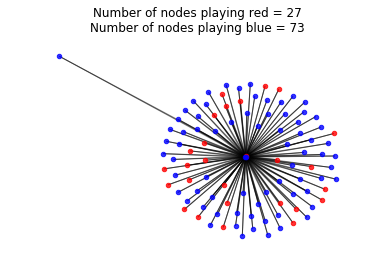

Convex switching function, R chooses unique vertex:


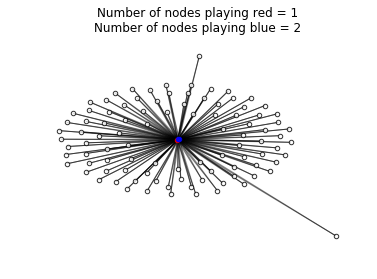

After contagion:
Iter = 1 # of nodes playing red = 1 
         # of nodes playing blue = 2
Iter = 2 # of nodes playing red = 38 
         # of nodes playing blue = 62


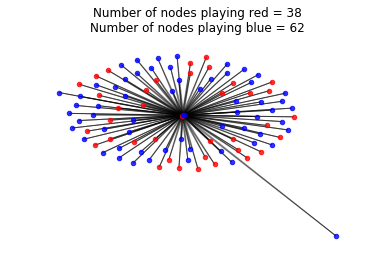

Convex switching function, R chooses unique vertex:
(50/50 chance that R claims vertex at all, not simulated here)


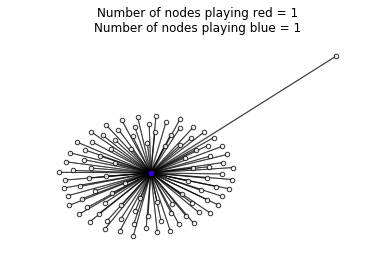

After contagion:
Iter = 1 # of nodes playing red = 1 
         # of nodes playing blue = 1
Iter = 2 # of nodes playing red = 10 
         # of nodes playing blue = 10


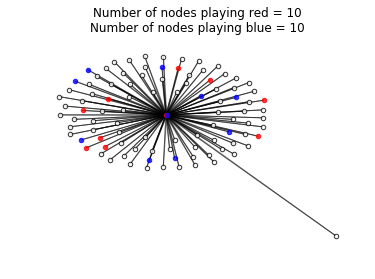

In [12]:
def example_graph_3(x, y, z):
    G=nx.Graph()
    G.clear()
    n = 100
    
    G.add_nodes_from(range(n))

    for i in range(3):
        for j in range(3, n):
            G.add_edge(i, j)

    r = [0 for i in range(n)]
    b = [0 for i in range(n)]

    r[x] = 1
    b[y] = 1
    if z != None:
        b[z] = 1
    
    return G, n, r, b

print("Linear switching function:")
G, n, r, b = example_graph_3(0, 1, 2)
original_r, original_b = save_r_b_copy(r, b, n)
draw_example_graph(G, n)
print("After contagion:")
run_cascade(r, b, 1, 1, n)
draw_example_graph(G, n)

print("Convex switching function, R chooses unique vertex:")
G, n, r, b = example_graph_3(0, 1, 2)
original_r, original_b = save_r_b_copy(r, b, n)
draw_example_graph(G, n)
print("After contagion:")
run_cascade(r, b, 4, 1, n)
draw_example_graph(G, n)

print("Convex switching function, R chooses unique vertex:")
print("(50/50 chance that R claims vertex at all, not simulated here)")
G, n, r, b = example_graph_3(0, 1, None)
original_r, original_b = save_r_b_copy(r, b, n)
draw_example_graph(G, n)
print("After contagion:")
run_cascade(r, b, 4, 1, n)
draw_example_graph(G, n)

# Other Models
Kearns et al. followed up the switching/selection model with two others, which mainly focus on altering the payoff function for the model while maintaining the same contagion/seeding mechanics.
### Connectivity Model
In this model, the payoff for a player is equal to the number of nodes infected by that player and the number of edges between nodes infected by that player.  This model attempts to capture competitive products where the connections between users are as critical as the number of users.  Kearns et al. use the examples of Skype vs AIM or facebook vs Google+ to illustrate how this model can be valuable.  I think this model is somewhat misleading.  Ultimately, for the companies that produce these products, the number of users they acquire is all that matters.  Connectivity between users is important only in so far as a properly coordinated network is an incentive that encourages a user to acquire or stick with the service.  This aspect of social networking is already modeled by the cascade effect, but it could be implemented even more precisely by, say, in a linear threshold model, increasing the influence of a product as its overall connectivity increases.
### Endogenous Budget Model
In this model, each player is allowed to set their own budget for initial seeding.  The payoff for each player is equal to some constant b, representing benefit, multiplied by the number of infections minus the initial seeds.  The cost of the player's budget, some constant c, representing cost, multiplied by the number of nodes initially seeded, is deducted from each player's payoff.  This model better represents that budgets for marketing a product are not limited arbitrarily to some value Kp; rather, a company can choose to increase marketing budgets if it predicts that there will be a greater than commensurate increase in payoffs.

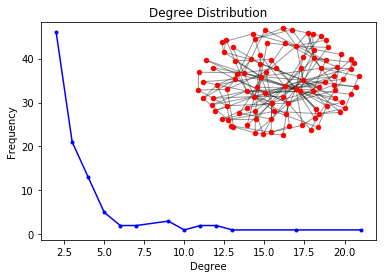

Iter = 1 # of nodes playing red = 1 
         # of nodes playing blue = 1
Iter = 2 # of nodes playing red = 56 
         # of nodes playing blue = 44


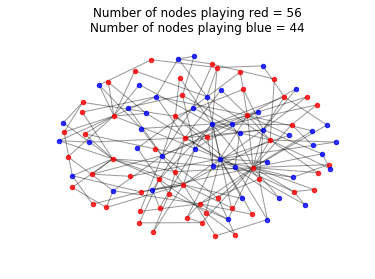

Original Model:
Payoff for Player R = 56
Payoff for Player B = 44
Connectivity Model:
Payoff for Player R = 118
Payoff for Player B = 79
Endogenous Budget Model:
Payoff for Player R = 54
Payoff for Player B = 42


In [11]:
n = 100
m = 2
G = create_graph(n, m)

r, b = reset_r_b(n)
run_cascade(r, b, 0, 0, n)
draw_graph(G, n)

#Payoff = number of vertices infected
def payoff_standard():
    payoff_r = sum(r)
    payoff_b = sum(b)
    print("Payoff for Player R =", payoff_r)
    print("Payoff for Player B =", payoff_b)
    #return payoff_r, payoff_b
 
#Payoff = number of vertices infected + number of edges between
#infected vertices
def payoff_connectivity():
    edges_r = 0
    edges_b = 0
    for i in G.edges():
        if r[i[0]] == 1 and r[i[1]] == 1:
            edges_r += 1
        if b[i[0]] == 1 and b[i[1]] == 1:
            edges_b += 1
    payoff_r = edges_r + sum(r)
    payoff_b = edges_b + sum(b)
    print("Payoff for Player R =", payoff_r)
    print("Payoff for Player B =", payoff_b)
    #return payoff_r, payoff_b

#Payoff = benefit constant * number of nonseed vertices infected
#          - cost * number of seed vertices (i.e. budget size)
benefit = 1
cost = 1
def payoff_endogenous_budget(benefit, cost):
    num_seed_r = sum(original_r)
    num_nonseed_r = sum(r) - num_seed_r
    num_seed_b = sum(original_b)
    num_nonseed_b = sum(b) - num_seed_b
    payoff_r = (benefit * num_nonseed_r) - (cost * num_seed_r)
    payoff_b = (benefit * num_nonseed_b) - (cost * num_seed_b)
    print("Payoff for Player R =", payoff_r)
    print("Payoff for Player B =", payoff_b)
    #return payoff_r, payoff_b

print("Original Model:")
payoff_standard()
print("Connectivity Model:")
payoff_connectivity()
print("Endogenous Budget Model:")
payoff_endogenous_budget(benefit, cost)

## Conclusion
More investigation can be done as to what real life situations correspond to different switching and selection functions, as well as different r and s values.  Once these relations between real life situations and our models can be established, these models could be implemented into corporate planning to suggest optimal marketing budgets and strategies.

I feel that the competitive contagion concept could also be well represented by a modification of the linear threshold model.  Such a model would capture elements of a competitive product environment that Kearns et al's model lacks.  For instance, the switching/selection model does not allow for product conversion, e.g. when the features of the new iPhone combined with the saturation of the product in my friend group convince me to convert from Android devices to iPhone.  Furthermore, such a model would better reflect that, when it comes to viral marketing and peer pressure to acquire a product, it is not so much the proportion of neighboring adopters that matters, but the number.  Under the switching/selection model, a node is 100% likely to acquire a contagion if it has one neighbor and that one neighbor is infected.  However, it might be more accurate to say that it takes at least 5 recommendations from one's acquaintances to convince a person to acquire a product, regardless of how many acquaintances one possesses.  Future work could be directed towards designing such a model more precisely.